In [ ]:
# Install necessary libraries
!pip install transformers datasets -q

# Disable wandb (Weights & Biases) integration to avoid API key prompts
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset
data_path = '/content/drive/MyDrive/subset_data.csv'  # Adjust path if needed
data = pd.read_csv(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                         id  \
0  ed0fed726929c1eeabe6c390e47128dbb7d7a055   
1  023cd84001b33aed4ff0f3f5ecb0fdd2151cf543   
2  6a70a0d8d3ed365fe1df6d35f1587a8b9b298618   
3  b37204c13ea38b511265e41ac69fb12acfb63f85   
4  c24e5805afd5145bc48410e876db91d44a06be5e   

                                             article  \
0  By . Mia De Graaf . Britons flocked to beaches...   
1  A couple who weighed a combined 32st were sham...   
2  Video footage shows the heart stopping moment ...   
3  Istanbul, Turkey (CNN) -- About 250 people rac...   
4  By . Daily Mail Reporter . PUBLISHED: . 12:53 ...   

                                          highlights  
0  People enjoyed temperatures of 17C at Brighton...  
1  Couple started piling on pounds after the birt...  
2  A 17-year-old boy suffering lacerations to his...  
3  Syrians citizens hightail it

### Text Preprocessing and EDA 

In [ ]:
# Preview the data
data.head()

,id,article,highlights
0,ed0fed726929c1eeabe6c390e47128dbb7d7a055,By . Mia De Graaf . Britons flocked to beaches...,People enjoyed temperatures of 17C at Brighton...
1,023cd84001b33aed4ff0f3f5ecb0fdd2151cf543,A couple who weighed a combined 32st were sham...,Couple started piling on pounds after the birt...
2,6a70a0d8d3ed365fe1df6d35f1587a8b9b298618,Video footage shows the heart stopping moment ...,A 17-year-old boy suffering lacerations to his...
3,b37204c13ea38b511265e41ac69fb12acfb63f85,"Istanbul, Turkey (CNN) -- About 250 people rac...",Syrians citizens hightail it to Turkey .\nMost...
4,c24e5805afd5145bc48410e876db91d44a06be5e,By . Daily Mail Reporter . PUBLISHED: . 12:53 ...,The Xue Long had provided the helicopter that ...


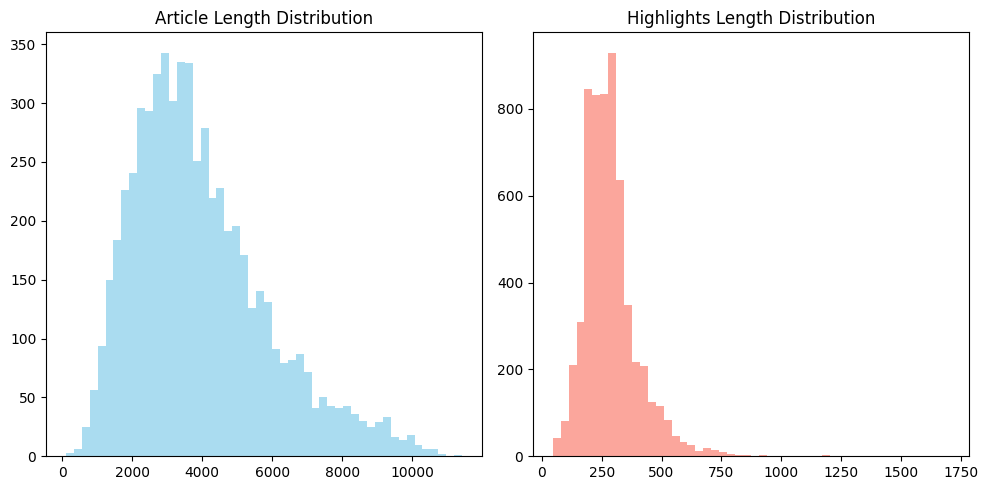

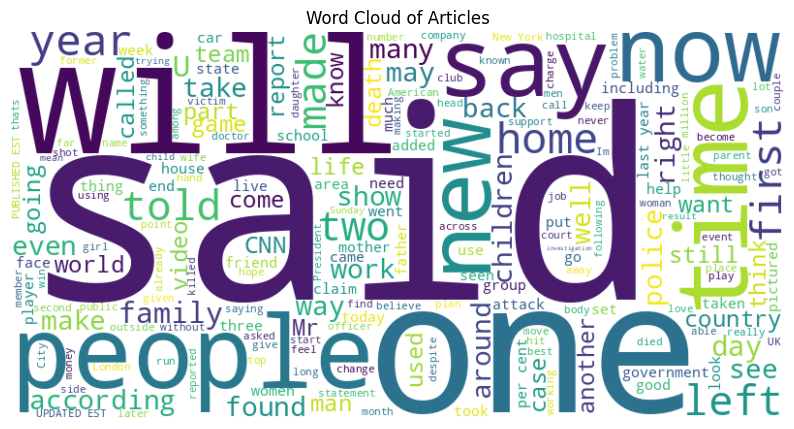

In [ ]:
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text cleaning function
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.strip()

# Clean text columns
data = data.dropna(subset=["article", "highlights"]).drop_duplicates()
data["article"] = data["article"].apply(clean_text)
data["highlights"] = data["highlights"].apply(clean_text)

# Visualize text lengths
data['article_length'] = data['article'].apply(len)
data['highlights_length'] = data['highlights'].apply(len)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(data['article_length'], bins=50, color='skyblue', alpha=0.7)
plt.title("Article Length Distribution")
plt.subplot(1, 2, 2)
plt.hist(data['highlights_length'], bins=50, color='salmon', alpha=0.7)
plt.title("Highlights Length Distribution")
plt.tight_layout()
plt.show()

# Generate a word cloud for articles
all_articles = " ".join(data['article'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_articles)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Articles")
plt.show()


### Article Length Distribution:
- Articles’ length distribution is nearly right-skewed with articles length ranging between 2000 and 5000 characters.
- This means that most of the articles contain reasonable amount of information. The most prevalent post length is clearly visible, hovering around the 3,000 to 4,000 character mark, and this is the optimal amount of information that social media users want to receive about a specific post.
- The majority of the articles falls in between 2000 and 8000 characters and a few are on the lower side of 1000 characters, but a few goes beyond more than 10,000 characters which can be excluded or may represent more detailed reports.
- This large a variation in length suggests variation in article difficulty that should be of concern for summarizing systems since more elaborate articles may need a better summarized algorithm.
### Highlights Length Distribution:
- Hence, highlights are much shorter and congested at one end of the distribution curve, in a positive skewed fashion where most are between 0 and 400 characters suggesting a need for short summaries. 
- The spike of frequency at around 200 is indicative of the fact that the majority of the texts have been probably summarized for the sake of brevity, and probably, to highlight few important points. 
- A mere 2.3% of highlights are longer than 1,000 characters and demonstrate that there is a pronounced pull toward summary writing. 
- This shortness is important in order to sustain the readers’ interest and demonstrates that future summarization models should focus on delivering the short snippets of the text which are actually usually provided by humans.
- These patterns clearly distinguish between the length of articles and brevity of highlights so will be useful in creating or refining text summarisation models that deal with inputs of different lengths.
### Word Cloud of Articles:
- The word “said” is the most frequent, which implies that the large part of the articles is devoted to the use of quotes or what people said. This coincidences with news reporting where the statements from individuals or organisations are often emphasized.
- Other frequently appeared words also refer to the future and events to come, people, the one and new. This creates the impression of a rather global approach of the articles’ topics with regard to real-life subjects and interferences in multiple spheres of life.
- The words used can be also identified as ‘police,’ ‘death,’ ‘home,’ ‘children’ thus referring to a ongoing popular topics, social issues, safety, and family’s events that can still be an issue in a society.
- Further, digits such as ‘year’, ‘now’ and ‘first’ also imply the relativity to time in the content, why many of the articles discuss current or future events.
- This is true because general terms such as ‘country’ and ‘life’ imply that the articles cover almost every aspect of social concern right from the affairs of a nation to our day to day life.

### Models For Summary

In [ ]:
from transformers import T5Tokenizer
from datasets import Dataset

# Convert pandas DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(data)

# Load the T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Preprocessing function
def preprocess_function(examples):
    inputs = ["summarize: " + article for article in examples["article"]]
    targets = examples["highlights"]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=150, truncation=True, padding="max_length").input_ids
    model_inputs["labels"] = labels
    return model_inputs

# Tokenize and preprocess the dataset
tokenized_data = dataset.map(preprocess_function, batched=True)

# Split into training and testing datasets
train_test_split = tokenized_data.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [ ]:
from transformers import T5ForConditionalGeneration, TrainingArguments, Trainer

# Load the T5 model
model = T5ForConditionalGeneration.from_pretrained("t5-small").to("cuda")

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,  # Adjust for GPU memory
    per_device_eval_batch_size=8,
    num_train_epochs=3,  # Adjust based on your dataset size
    save_steps=500,
    save_total_limit=2,
    fp16=True,  # Mixed precision for faster computation
    logging_dir='./logs',
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.532400,1.056386
2,1.098200,1.040359
3,1.072100,1.037217


TrainOutput(global_step=1800, training_loss=1.2047736782497829, metrics={'train_runtime': 436.5952, 'train_samples_per_second': 32.983, 'train_steps_per_second': 4.123, 'total_flos': 1948921941196800.0, 'train_loss': 1.2047736782497829, 'epoch': 3.0})

### Training Loss Decreasing:
The Training Loss comes down progressively through epochs (1.532400, 1.098200, 1.072100). This they opine can imply that the model is learning from the training data and enhancing its capability in making the error as low as possible during training.

### Validation Loss Stagnation:
* The above output shows that validation loss reduces partially (from 1.056386 to 1.040359) but later remain almost constant (1.040359 to 1.037217). This could mean:

* This means that the model has learned from the validation set, but is not improving from further, greatly.
Chen et al have claimed that the curation of large datasets may reach the maximum number of features that model can learn with the current architecture .

### Save the model and tokenizer

In [ ]:
# Save the model and tokenizer
output_path = '/content/drive/MyDrive/t5_fine_tuned'
model.save_pretrained(output_path)
tokenizer.save_pretrained(output_path)
print(f"Model saved to {output_path}!")

Model saved to /content/drive/MyDrive/t5_fine_tuned!


### T5Tokenizer Model

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Path to the saved model
model_path = '/content/drive/MyDrive/t5_fine_tuned'

# Load the saved tokenizer and model
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path).to("cuda")


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

###  Generate a summary

In [ ]:
def summarize_text(article, max_input_length=512, max_output_length=150):
    """
    Generate a summary for the given article using the fine-tuned T5 model.
    """
    # Prepare the input
    input_text = "summarize: " + article
    inputs = tokenizer(input_text, return_tensors="pt", max_length=max_input_length, truncation=True).to("cuda")

    # Generate the summary
    outputs = model.generate(
        inputs.input_ids,
        max_length=max_output_length,
        num_beams=4,
        early_stopping=True
    )

    # Decode and return the summary
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


### Testing on the first 5 rows of the dataset

In [ ]:
# Example: Test on the first 5 rows of the dataset
for i in range(5):
    article = data.loc[i, 'article']
    true_summary = data.loc[i, 'highlights']
    predicted_summary = summarize_text(article)

    print(f"Article: {article[:300]}...")  # Show a snippet of the article
    print(f"True Summary: {true_summary}")
    print(f"Predicted Summary: {predicted_summary}")
    print("-" * 80)


Article: By  Mia De Graaf  Britons flocked to beaches across the southern coast yesterday as millions look set to bask in glorious sunshine today Temperatures soared to 17C in Brighton and Dorset with people starting their long weekend in deck chairs by the sea Figures from Asda suggest the unexpected sunshi...
True Summary: People enjoyed temperatures of 17C at Brighton beach in West Sussex and Weymouth in Dorset  Asda claims it will sell a million sausages over long weekend despite night temperatures dropping to minus 1C  But the good weather has not been enjoyed by all as the north west and Scotland have seen heavy rain
Predicted Summary: Forecasters predict dry and sunny weather across southern England southern Wales and the south Midlands
--------------------------------------------------------------------------------
Article: A couple who weighed a combined 32st were shamed into slimming by their own family  during Christmas dinner Margaret Gibson 37 and her husband James 41 from

### Another example for testing

In [ ]:
# New article example
new_article = "The quick brown fox jumps over the lazy dog. The fox is very agile and clever, often outwitting its predators. This article explores the unique adaptations of foxes that make them extraordinary creatures in the wild."
new_summary = summarize_text(new_article)

print(f"New Article: {new_article}")
print(f"Predicted Summary: {new_summary}")


New Article: The quick brown fox jumps over the lazy dog. The fox is very agile and clever, often outwitting its predators. This article explores the unique adaptations of foxes that make them extraordinary creatures in the wild.
Predicted Summary: The fox is very agile and clever, often outwitting its predators.


### Example with a lengthy document

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Path to the saved model
model_path = '/content/drive/MyDrive/t5_fine_tuned'

# Load the saved tokenizer and model
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path).to("cuda")

def summarize_text(article, max_input_length=512, max_output_length=150):
    """
    Generate a summary for the given article using the fine-tuned T5 model.
    Handles chunking for lengthy articles.
    """
    # Prepare the input
    input_text = "summarize: " + article
    inputs = tokenizer(input_text, return_tensors="pt", max_length=max_input_length, truncation=True).to("cuda")

    # Generate the summary
    outputs = model.generate(
        inputs.input_ids,
        max_length=max_output_length,
        num_beams=4,
        early_stopping=True
    )

    # Decode and return the summary
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def summarize_long_text(article, max_input_length=512, max_output_length=150):
    """
    Summarize lengthy articles by chunking them into smaller parts.
    """
    chunks = [article[i:i + max_input_length] for i in range(0, len(article), max_input_length)]
    summarized_chunks = [summarize_text(chunk, max_input_length, max_output_length) for chunk in chunks]
    return " ".join(summarized_chunks)

# Example with a lengthy document
lengthy_article = """
Foxes are small to medium-sized omnivorous mammals belonging to several genera of the family Canidae.
Foxes have a flattened skull, upright triangular ears, a pointed, slightly upturned snout, and a long bushy tail.
There are about 37 species referred to as foxes. Only 12 species belong to the monophyletic "true foxes" group of genus Vulpes.
Foxes live on every continent except Antarctica. The most common and widespread species of fox is the red fox (Vulpes vulpes) with about 47 recognized subspecies.
The global distribution of foxes, along with their widespread reputation for cunning, has contributed to their prominence in popular culture and folklore in many societies around the world.
...
(Include several paragraphs here to create a long article)
"""

# Summarize the lengthy article
lengthy_summary = summarize_long_text(lengthy_article)

print(f"Lengthy Article: {lengthy_article[:500]}...")  # Print a snippet of the article
print(f"Predicted Summary for Lengthy Article: {lengthy_summary}")


Lengthy Article: 
Foxes are small to medium-sized omnivorous mammals belonging to several genera of the family Canidae. 
Foxes have a flattened skull, upright triangular ears, a pointed, slightly upturned snout, and a long bushy tail. 
There are about 37 species referred to as foxes. Only 12 species belong to the monophyletic "true foxes" group of genus Vulpes. 
Foxes live on every continent except Antarctica. The most common and widespread species of fox is the red fox (Vulpes vulpes) with about 47 recognized s...
Predicted Summary for Lengthy Article: Foxes are small to medium-sized omnivorous mammals belonging to several genera of the family Canidae. only 12 species belong to the monophyletic "true foxes" group of genus Vulpes. The global distribution of foxes has contributed to their prominence in popular culture and folklore in many societies around the world
